┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.888e+04                  │              Nfcn = 93               │
│ EDM = 7.6e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

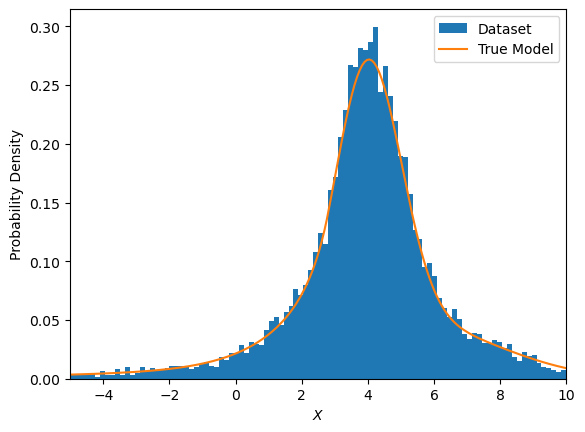

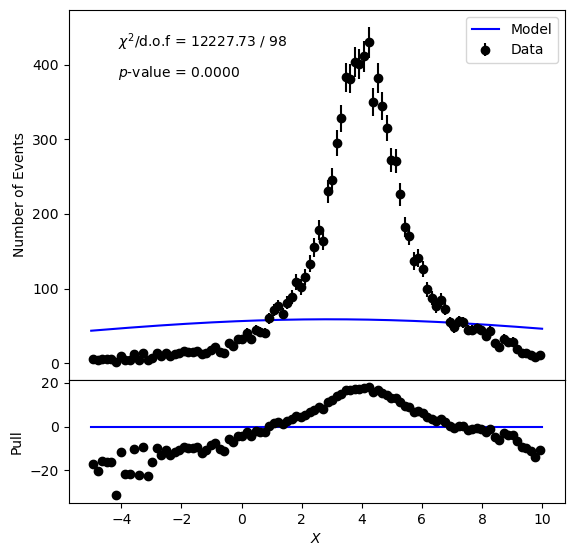

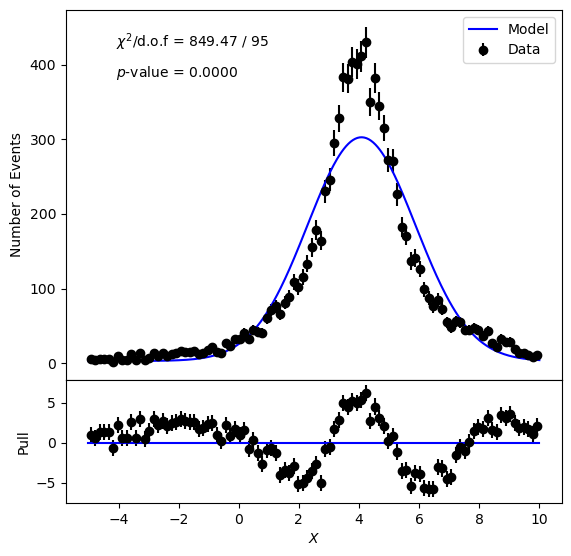

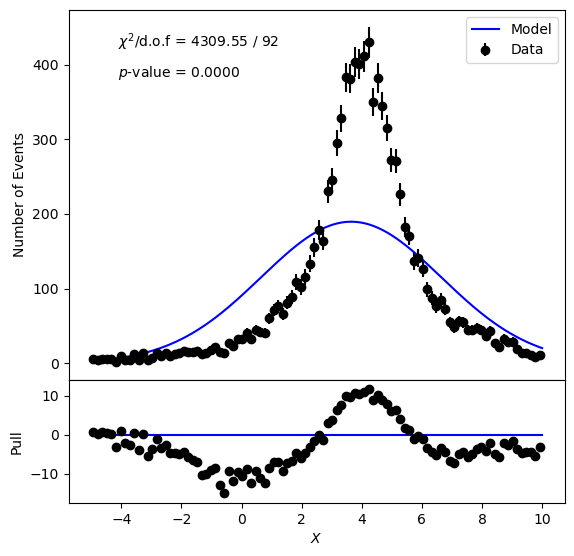

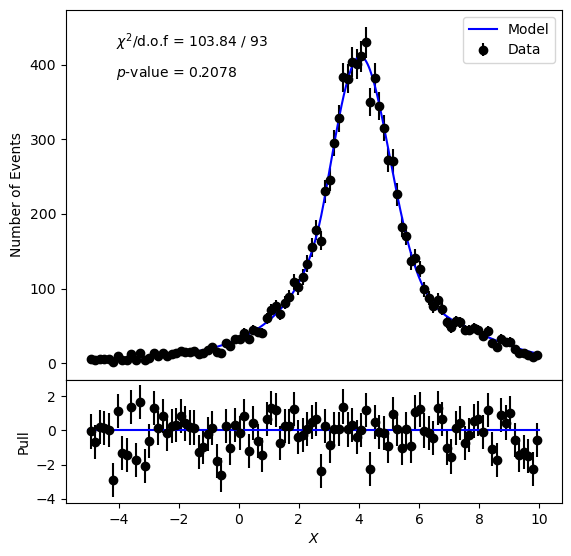

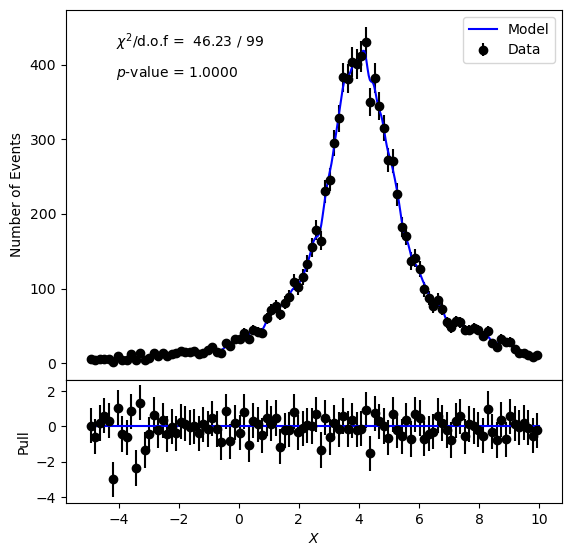

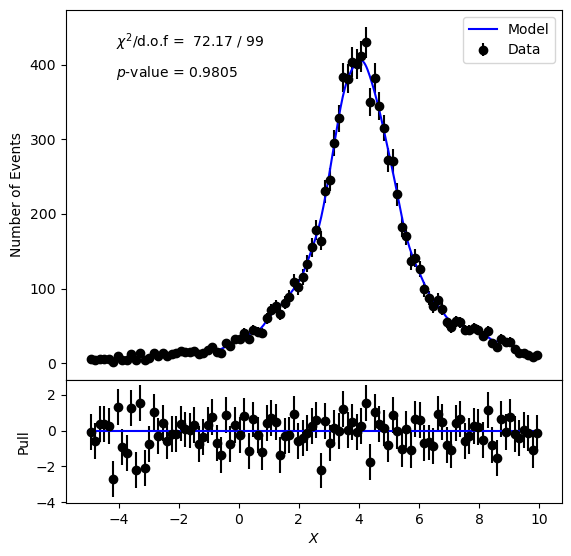

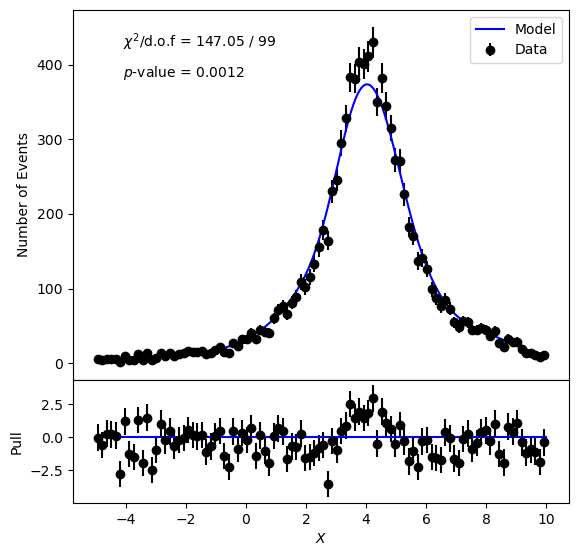

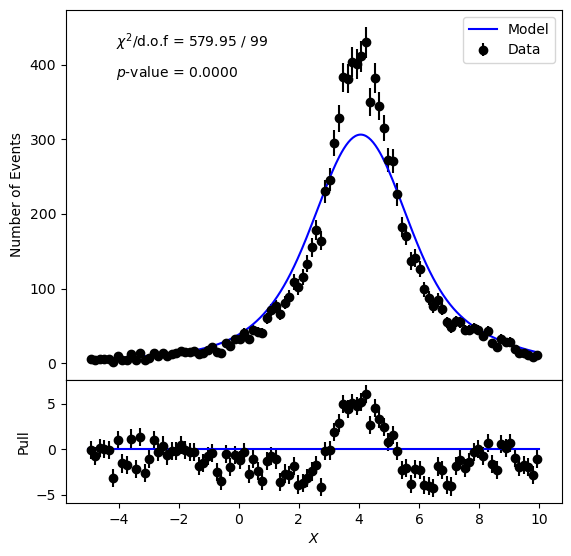

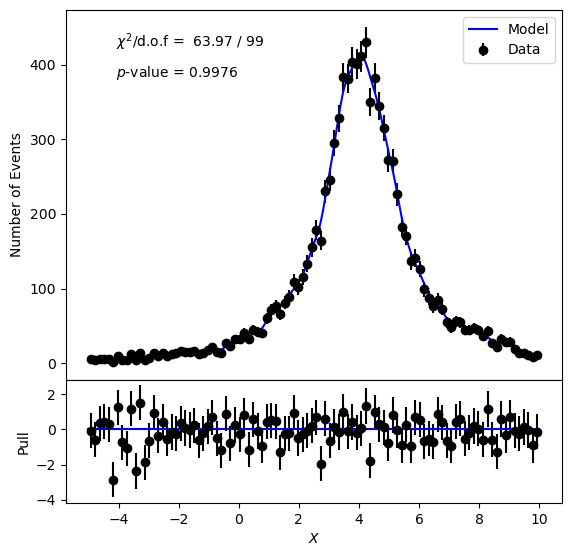

In [2]:
import numpy as np
from scipy.stats import crystalball as cbgen, norm as normgen, chi2, gaussian_kde
from numba_stats import crystalball, norm
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
from sklearn.neighbors import KernelDensity

xrange = (-5,10)

# true pars
beta = 1.2
mfac = 2
cbmu = 4
cbsg = 1
frac = 0.7
gsmu = 5.3
gssg = 2.6

# generation
load = True

np.random.seed(210187)
Ngen = 10000
Ncb = int( frac*Ngen )
Ngs = Ngen - Ncb

cbshape = cbgen(beta=beta, m=mfac, loc=cbmu, scale=cbsg)
gsshape = normgen(loc=gsmu, scale=gssg)

if not load:
    dset = np.concatenate( [ cbshape.rvs(size=Ncb), gsshape.rvs(size=Ngs) ] )
    np.random.shuffle(dset)
    np.save('peaking.npy', dset)

else:
    dset = np.load('peaking.npy')

# true model
def model(x, f, bt, mc, m1, s1, m2, s2):
    cb = crystalball.pdf(x, bt, mc, m1, s1)
    gs = norm.pdf(x, m2, s2)
    return f*cb + (1-f)*gs

def true_model(x):
    return model(x, f=frac, bt=beta, mc=mfac, m1=cbmu, s1=cbsg, m2=gsmu, s2=gssg)

# plot truth and date
fig, ax = plt.subplots()
ax.hist(dset, bins=100, range=xrange, density=True, label='Dataset')
x = np.linspace(*xrange,200)
ax.plot(x, true_model(x), label='True Model' )
ax.set_xlim(*xrange)
ax.set_xlabel('$X$')
ax.set_ylabel('Probability Density')
ax.legend()
fig.savefig('kde_truth.pdf')

# now try a few different fits
def plot( dset, model, npars, nbins=100, save=None ):
    

    fig, ax = plt.subplots(2, 1, height_ratios=[3,1], gridspec_kw={'hspace':0}, figsize=(6.4,6.4))
    
    # plot data
    nh, xe = np.histogram( dset, bins=nbins, range=xrange )
    cx = 0.5*(xe[1:]+xe[:-1])
    ax[0].errorbar(cx, nh, nh**0.5, fmt='ko', label='Data')

    # plot model
    bw = xe[1]-xe[0]
    N = len(dset)
    x = np.linspace(*xrange, 400)
    ax[0].plot(x, N*bw*model(x), 'b-', label='Model')

    # plot residual
    y = N*bw*model(cx)
    p = (nh-y)/(nh**0.5)
    ax[1].errorbar(cx, p, np.ones_like(p), fmt='ko')
    ax[1].plot(x, np.zeros_like(x), 'b-')

    ax[0].set_ylabel('Number of Events')
    ax[1].set_xlabel('$X$')
    ax[1].set_ylabel('Pull')

    # compute chi2
    ndof = nbins - npars
    chisq = np.sum( p**2 )
    chisq_per_dof = chisq / ndof
    pval = chi2.sf( chisq, ndof )

    ax[0].text(0.1, 0.90, f'$\chi^2 / $d.o.f = {chisq:6.2f} / {ndof}', transform=ax[0].transAxes)
    ax[0].text(0.1, 0.82, f'$p$-value = {pval:6.4f}', transform=ax[0].transAxes)

    ax[0].legend()

    if save is not None:
        fig.savefig(save)

# single normal 
def g1_model(x, m1, s1):
    return norm.pdf(x, m1, s1)

# double normal
def g2_model(x, f, m1, s1, m2, s2):
    return f*norm.pdf(x, m1, s1) + (1-f)*norm.pdf(x, m2, s2)

# triple normal
def g3_model(x, f1, f2, m1, s1, m2, s2, m3, s3):
    return f1*norm.pdf(x, m1, s1) + f2*norm.pdf(x, m2, s2) * (1-f1-f2)*norm.pdf(x, m3, s3)

g1_cost = cost.UnbinnedNLL( dset, g1_model )
g1_mi = Minuit( g1_cost, m1=3, s1=1 )
g1_mi.limits['m1'] = (2,6)
g1_mi.limits['s1'] = (0,15)
g1_mi.migrad()
g1_mi.hesse()
print(g1_mi)
g1_res = lambda x: g1_model(x, *g1_mi.values)
plot( dset, g1_res, npars=len(g1_mi.values), save='kde_g1.pdf' )

g2_cost = cost.UnbinnedNLL( dset, g2_model )
g2_mi = Minuit( g2_cost, f=0.3, m1=3, s1=1, m2=1, s2=3)
g2_mi.limits['m1','m2'] = (2,6) 
g2_mi.limits['s1'] = (0,3)
g2_mi.limits['s2'] = (0,20)
g2_mi.limits['f'] = (0,0.9)
g2_mi.migrad()
g2_mi.hesse()
print(g2_mi)
g2_res = lambda x: g2_model(x, *g2_mi.values)
plot( dset, g2_res, npars=len(g2_mi.values), save='kde_g2.pdf' )

g3_cost = cost.UnbinnedNLL( dset, g3_model )
g3_mi = Minuit( g3_cost, f1=0.6, f2=0.3, m1=3, s1=1, m2=1, s2=3, m3=4, s3=4)
g3_mi.limits['m1','m2','m3'] = (0,8) 
g3_mi.limits['s1','s2'] = (0,3)
g3_mi.limits['s3'] = (0,20)
g3_mi.limits['f1','f2'] = (0,0.95)
g3_mi.migrad()
g3_mi.hesse()
print(g3_mi)
g3_res = lambda x: g3_model(x, *g3_mi.values)
plot( dset, g3_res, npars=len(g3_mi.values), save='kde_g3.pdf' )

ok_cost = cost.UnbinnedNLL( dset, model )
ok_mi = Minuit( ok_cost, f=frac, bt=beta, mc=mfac, m1=cbmu, s1=cbsg, m2=gsmu, s2=gssg )
ok_mi.limits['m1','m2'] = xrange
ok_mi.limits['s1','s2'] = (0,15)
ok_mi.limits['f'] = (0,0.95)
ok_mi.migrad()
ok_mi.hesse()
print(ok_mi)
ok_res = lambda x: model(x, *ok_mi.values)
plot( dset, ok_res, npars=len(ok_mi.values), save='kde_cbg.pdf' )

kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(dset.reshape(-1,1))
f_kde = lambda x: np.exp( kde.score_samples(x.reshape(-1,1)) )
plot( dset, f_kde, npars=1, save='kde_01.pdf')

kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(dset.reshape(-1,1))
f_kde = lambda x: np.exp( kde.score_samples(x.reshape(-1,1)) )
plot( dset, f_kde, npars=1, save='kde_02.pdf')

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dset.reshape(-1,1))
f_kde = lambda x: np.exp( kde.score_samples(x.reshape(-1,1)) )
plot( dset, f_kde, npars=1, save='kde_05.pdf')

kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(dset.reshape(-1,1))
f_kde = lambda x: np.exp( kde.score_samples(x.reshape(-1,1)) )
plot( dset, f_kde, npars=1, save='kde_1.pdf')

kde = KernelDensity(kernel="gaussian", bandwidth='scott').fit(dset.reshape(-1,1))
f_kde = lambda x: np.exp( kde.score_samples(x.reshape(-1,1)) )
plot( dset, f_kde, npars=1, save='kde_scott.pdf')

plt.show()